In [1030]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import zuko
import lampe.inference, lampe.utils
import matplotlib.pyplot as plt
import tqdm
import sklearn
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [1031]:
data_papier = np.load("/home/tux/rnpe/data.npy",allow_pickle=True)
data_papier.item().keys()

dict_keys(['theta', 'theta_true', 'x', 'y', 'y_raw'])

In [1032]:
prior_over_mu = torch.distributions.Normal(torch.zeros(1), torch.ones(1)*5)

In [1033]:
mu = data_papier.item()['theta_true'].item()
mu = prior_over_mu.sample().item()
mu = 0
theta_papier = data_papier.item()['theta']

x_papier = data_papier.item()['x']

y_papier = data_papier.item()['y']

y_raw_papier = data_papier.item()['y_raw']

In [1034]:
mu

0

In [1035]:
N = 50000
sigma = 0.01
tau = 0.25
rho = 1/2

Utils

In [1036]:
def generate_observed_corrupted_data(N, mu, epsilon):
    zx = mu + torch.distributions.Normal(0, 1).sample((N, 100))
    zy = zx + torch.distributions.Normal(0, epsilon).sample(zx.shape)
    y_raw = torch.cat((zy.mean(dim=1, keepdim=True), zy.var(dim=1, keepdim=True)), dim=-1)
    return y_raw

In [1037]:
def simulator(N_train,N_test, prior):
    N = N_train + N_test
    theta = prior.sample((N, ))
    
    sample = torch.distributions.Normal(theta.unsqueeze(1), 1.0).sample((100, ))
    
    x_raw = torch.cat((sample.mean(dim=0, keepdim=True), sample.var(dim=0, keepdim=True)), dim=2).squeeze_()
    
    return theta, x_raw

In [1038]:
def scale(quantity):
    means = quantity.mean(0)
    stds = quantity.std(0)
    return (quantity-means)/stds, means, stds

In [1039]:
theta_raw_f, x_raw_f = simulator(N, N//10, prior_over_mu)
x, x_test = x_raw_f.split(N)
x, x_mean, x_std = scale(x)
x_test, x_test_mean, x_test_std = scale(x_test)
theta, theta_test = theta_raw_f.split(N)
theta, theta_mean, theta_std = scale(theta)
theta_test, theta_test_mean, theta_test_std = scale(theta_test)


In [1040]:
dataset = lampe.data.JointDataset(theta, x)
dataset_test = lampe.data.JointDataset(theta_test, x_test)

y_raw = generate_observed_corrupted_data(N, mu, 1)
y = (y_raw[0] - x_mean) / x_std
y

tensor([0.0213, 7.8079])

Simulation (line 1 & 2 of Algorithm 1)

In [1041]:
def train_NPE(flow, data, loss,theta_test, x_test, learning_rate=5*10e-4, max_epochs=50,batch_size=256,patience=5):
    """Trains a NPE.

    Args:
        flow (lampe.inference.NPE): A instanciated flow
        data (lampe.data.JointDataset): dataset (theta, x)
        loss (callable): a loss function
        theta_test (torch.Tensor): test batch
        x_test (torch.Tensor): test batch
        learning_rate (float, optional): Defaults to 5*10e-4.
        max_epochs (int, optional): Defaults to 50.
        batch_size (int, optional): Defaults to 256.
        patience (int, optional): Defaults to 5.

    Returns:
        lampe.inference.NPE: the trained NPE
    """
    
    #Optim
    optimizer = torch.optim.Adam(flow.parameters(), learning_rate)
    step = lampe.utils.GDStep(optimizer)
    #Creates the loader
    loader = lampe.data.DataLoader(data, batch_size)
    #For early stopping
    with torch.no_grad():
        min_loss = loss(theta_test,x_test)
    min_loss_list = [min_loss]
    
    flow.train()
    #batch_norm_x = torch.nn.BatchNorm1d(x_test.shape[1])
    #batch_norm_theta = torch.nn.BatchNorm1d(theta_test.shape[1])
    for epoch in tqdm.tqdm(range(max_epochs)):
        
        for theta_batch_raw, x_batch_raw in loader:
            #theta_batch = batch_norm_theta(theta_batch_raw)
            #x_batch = batch_norm_x(x_batch_raw)
            theta_batch = theta_batch_raw
            x_batch = x_batch_raw
            losses = loss(theta_batch, x_batch)
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            
            #batch_norm_theta(theta_batch_raw)
            #batch_norm_x(x_batch_raw)
        
        #Checking for early stopping
        with torch.no_grad():
            loss_test = loss(theta_test, x_test)
            min_loss_list.append(loss_test)
            if len(min_loss_list) - np.argmin(min_loss_list) > patience:
                print(f" Early stop at epoch {epoch}")
                break
    flow.eval()
    return flow

In [1042]:
def train_unconditional(flow, x, x_test, loss, learning_rate=1e-2,max_epochs=50, batch_size=256, patience=5):
    """Train an unconditional flow

    Args:
        flow (zuko.flow): A instanciated flow
        x (torch.Tensor): 
        x_test (torch.Tensor): test batch
        loss (callable): a loss function
        learning_rate (float, optional): Defaults to 1e-3.
        max_epochs (int, optional): Defaults to 50.
        batch_size (int, optional): Defaults to 256.
        patience (int, optional): Defaults to 5.

    Returns:
        zuko.flow: the trained flow
    """
    
    #Optim
    optimizer = torch.optim.Adam(flow.parameters(), learning_rate)
    
    #Creates the loader
    loader = torch.utils.data.DataLoader(x, batch_size)
    min_loss_list = []
    #Early stopping
    with torch.no_grad():
        min_loss = loss(x_test)
    min_loss_list = [min_loss]
    
    flow.train()
    for epoch in tqdm.tqdm(range(max_epochs)):
        
        for x_batch in loader:
        
            losses = loss(x_batch)
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
        #Checking for early stopping
        with torch.no_grad():
            loss_test = loss(x_test)
            min_loss_list.append(loss_test)
            if len(min_loss_list) - np.argmin(min_loss_list) > patience:
                print(f"Early stop at epoch {epoch}")
                break
    return flow

Train NPE q(theta|x) on the simulated dataset {(thetai, xi)}, i=1, ... N
Uses a neural spline flow defining the transform on the interval [-5, 5] using 10  spline segments and 5 coupling layers. The base of the flow is a standard Gaussian distribution. 

In [1043]:
def build_nsf(features, context):
    """Callable to instanciate the NPE with NSFs"""
    return zuko.flows.NSF(features, context, bins=10, transforms=5)

q_NPE = lampe.inference.NPE(theta_dim = 1, x_dim=2, build=build_nsf)
loss_NPE = lampe.inference.NPELoss(q_NPE)
q_NPE = train_NPE(q_NPE, dataset, loss_NPE, theta_test, x_test)
'''
q_NPE_noisy = lampe.inference.NPE(theta_dim = 1, x_dim = 2, build=build_nsf)
loss_NPE_noisy = lampe.inference.NPELoss(q_NPE_noisy)
q_NPE_noisy = train_NPE(q_NPE_noisy, dataset_noisy, loss_NPE_noisy, theta_test_noisy, x_test_noisy)    
'''

  0%|          | 0/50 [00:00<?, ?it/s]

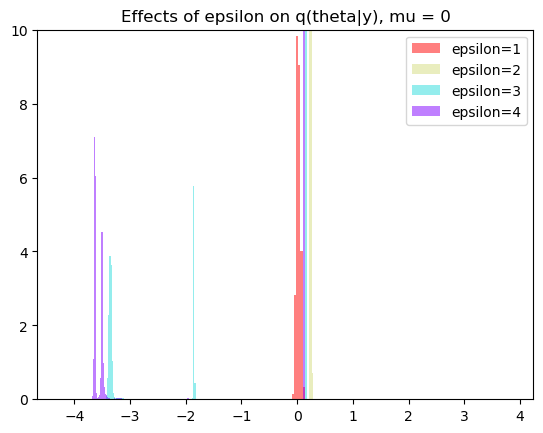

In [ ]:
def plot_corruption_effect(epsilons, npe):
    d = {}
    for epsilon in epsilons:
        y = generate_observed_corrupted_data(N,mu,epsilon)[0]
        y = (y-x_mean)/x_std
        d[epsilon] = npe.sample(y, (N, ))
    colors = plt.cm.rainbow_r(np.linspace(0, 1, len(d)))
    for i, (epsilon, posterior) in enumerate(d.items()):
        plt.hist(posterior.detach().numpy(), bins=200, alpha=0.5, color=colors[i], label=f"epsilon={epsilon}", density=True)
    plt.legend()
    plt.ylim(top=10)
    plt.title(f"Effects of epsilon on q(theta|y), mu = {mu}")
        
plot_corruption_effect([1,2,3, 4], q_NPE)
        

### Sampling theta here as in the 'classic' NPE framework (i.e. assuming no error)

In [ ]:
thetas_NPE = q_NPE.sample(y, (N, ))

#thetas_NPE_noisy = q_NPE_noisy.sample(y,(x_noisy.shape[0], ))

Train q(x) on {xi} i=1, ... N (so first gen the x)
For q(x) uses of a block neural autoregressive flow, single hidden layer of size 8D, x in R^d

In [ ]:
q_x_NF = zuko.flows.NAF(features = 2, context=0, hidden_features=[8]*2)
loss_q_x = lambda x: -q_x_NF().log_prob(x).mean()
q_x_NF = train_unconditional(q_x_NF, x, x_test, loss_q_x)
#q_x_NF = train_unconditional(q_x_NF, x_raw, x_test, loss_q_x)

 12%|█▏        | 6/50 [00:30<03:43,  5.07s/it]

Early stop at epoch 6


Sample x~m from p(x | y0) % p(y0 \ x) q(x), m = 1, ... M using MCMC

Spike and slab

In [ ]:
M = 100000
warm_up_steps = 20000
traj_length = 1
target_acceptance_prob = 0.95

In [ ]:
class MHQTransition(lampe.inference.MetropolisHastings):
    def q(self, x:torch.Tensor):
        return q_x_NF()

Suppose we observe y0

In [ ]:
y0 = y
#y0 = y_raw[0]

Sampling thetasm 

Comparaisons

In [ ]:
def compare(flow,x,file):
    class1 = file
    post = flow.flow(x).sample((class1.shape[0], ))
    print(post.shape)
    #post = scale(post)
    post_array = post.detach().numpy()
    class0 = post_array
    class0_labels = np.zeros(len(class0))
    class1_labels = np.ones(len(class1))
    data = np.concatenate((class0,class1), axis=0)
    labels = np.concatenate((class0_labels, class1_labels), axis=0)
    X_train, X_test, y_train, y_test = train_test_split(data,labels)

    clf = QuadraticDiscriminantAnalysis()
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    acc = sklearn.metrics.accuracy_score(y_test,y_pred)
    return acc
    

NPE 

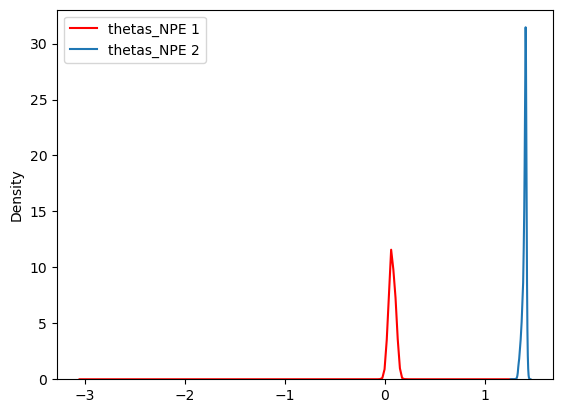

In [ ]:
import seaborn as sns
sns.kdeplot(thetas_NPE.squeeze().detach().numpy(),color='red', label='thetas_NPE 1')
sns.kdeplot(np.load("/home/tux/rnpe/naive_samples_papers.npy"),color='blue', label='thetas_NPE 2')

plt.legend()
plt.show()

Les thetasm directement

In [ ]:
#file = np.load("/home/tux/rnpe/robust_samples_paper.npy", allow_pickle=True)
#compare(q_NPE,xm_samples,file)

In [ ]:
x_props = q_x_NF().sample((warm_up_steps+M, ))

In [ ]:
x_props = x_props[~x_props.isinf().any(dim=1)]

In [ ]:
def proposal(x_curr):
    random_x = torch.randint(low=0, high= x_props.shape[0], size=(1, ))
    return x_props[random_x][0]
    #return q_x_NF().sample()
    return x_curr + torch.distributions.Normal(0,1).sample(x_curr.shape)


def f(y0, x): #% to p(x |y0)
    D = 2
    res = torch.zeros_like(y0)

    
    for j in range(D):
        xj = x[j]
        yj = y0[j]
        zj = torch.distributions.Bernoulli(rho).sample()
        if not zj:
            spike_dist =  torch.distributions.Normal(torch.tensor(xj.clone().detach()), torch.tensor(sigma))
            res[j] = torch.exp(spike_dist.log_prob(yj))

            
        else:
            
            slab_dist = torch.distributions.Cauchy(torch.tensor(xj.clone().detach()), torch.tensor(tau))
            res[j] = torch.exp(slab_dist.log_prob(yj))

    return res


def mcmc(x0, warm_up_steps, M):
    x_curr = x0
    my_samples = torch.empty((warm_up_steps+M, x0.shape[0]))
    log_f_x_curr = f(y0, x_curr).log()
    for i in tqdm.tqdm(range(warm_up_steps+M)):
        x_star = proposal(x_curr)
        log_f_x_star = f(y0, x_star).log()

        log_a = log_f_x_star - log_f_x_curr

        a = torch.exp(log_a)

    
        u = torch.rand(a.shape).to(a)

        mask = u < a

        x_curr = torch.where(mask, x_star, x_curr)
        log_f_x_curr = torch.where(mask, log_f_x_star, log_f_x_curr)
    
        my_samples[i] = x_curr
    my_samples = my_samples[warm_up_steps:]
    return my_samples

my_samples = mcmc(torch.zeros_like(x[0]), warm_up_steps, M)

/tmp/ipykernel_3432/596878230.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  slab_dist = torch.distributions.Cauchy(torch.tensor(xj.clone().detach()), torch.tensor(tau))
  0%|          | 0/120000 [00:00<?, ?it/s]/tmp/ipykernel_3432/596878230.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spike_dist =  torch.distributions.Normal(torch.tensor(xj.clone().detach()), torch.tensor(sigma))
100%|██████████| 120000/120000 [00:39<00:00, 3015.31it/s]


In [ ]:
my_samples_unscaled = (my_samples + x_mean) *x_std
thetas_m = q_NPE.sample(my_samples)

<Axes: ylabel='Density'>

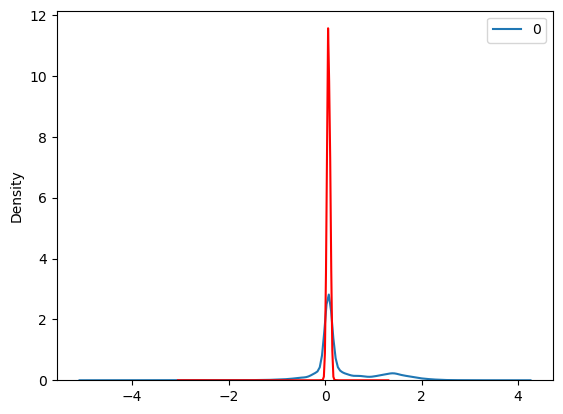

In [ ]:
sns.kdeplot(thetas_m)
sns.kdeplot(thetas_NPE.squeeze(),c='red')

/home/tux/miniconda3/envs/rnpe_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(x, float)


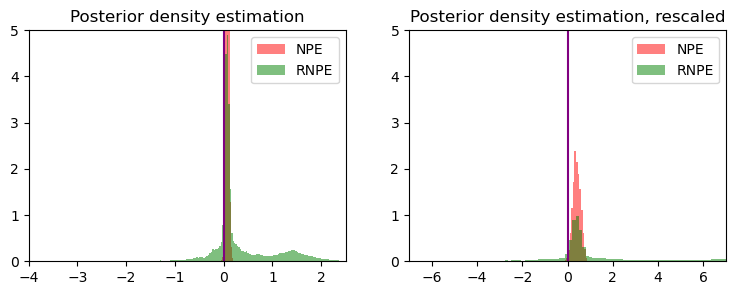

In [ ]:
def plot_thetas_scaled(thetas_NPE, thetasm): #,thetas_NPE_noisy
    n_bins= 300
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(9, 3))
    
    ax1.hist(thetas_NPE.squeeze().detach().numpy(),bins=n_bins, alpha=0.5, color='r', label='NPE', density=True)
    ax1.hist(thetasm.squeeze().detach().numpy(),bins=n_bins, alpha = 0.5, color='g', label='RNPE', density=True)
    mu_sclaled = (mu - theta_mean)/theta_std
    ax1.axvline(x=mu_sclaled,color="purple")
    ax1.axis(xmin=-4,xmax= 2.5)
    ax1.axis(ymax=5)
    ax1.legend()
    ax1.set_title("Posterior density estimation")
    
    ax2.hist(((thetas_NPE.squeeze() + theta_mean)*theta_std).detach().numpy(), bins=n_bins,alpha=0.5, color='r', label='NPE',density=True)
    ax2.hist(((thetasm.squeeze()+theta_mean)*theta_std).detach().numpy(), bins=n_bins, alpha=0.5, color='g', label='RNPE', density=True)
    ax2.axis(xmin=-7,xmax= 7)
    ax2.axis(ymax=5)
    ax2.axvline(x=mu,color="purple")
    ax2.legend()
    ax2.set_title("Posterior density estimation, rescaled")
    plt.show()

plot_thetas_scaled(thetas_NPE, thetas_m)#,thetas_NPE_noisy)
#TODO Plot true post

In [ ]:
def plot_log_probs(flow, x, y, theta_star):
    
    with torch.no_grad():
        log_probs_NPE = [flow.flow(xj).log_prob(theta_star) for xj in tqdm.tqdm(x)]
        
        log_probs_RNPE = [flow.flow(xmj).log_prob(theta_star) for xmj in tqdm.tqdm(my_samples)]
        
        #log_probs_NNPE = [flow.flow(xnj).log_prob(theta_star) for xnj in tqdm.tqdm(x_noisy)]
    
    fig, ax = plt.subplots()
    boxplot = ax.boxplot([log_probs_NPE, log_probs_RNPE], showmeans=True)
    for box in boxplot['boxes']:
        box.set(color='black', linewidth=1.5)
    for whisker in boxplot['whiskers']:
        whisker.set(color='black', linewidth=1.5)
    for cap in boxplot['caps']:
        cap.set(color='black', linewidth=1.5)
    for median in boxplot['medians']:
        median.set(color='red', linewidth=1.5)
    ax.set_xticklabels(['NPE', 'RNPE'])
    ax.set_xlabel('Model')
    ax.set_ylabel('Log Probability')
    ax.set_title('Log Probability for NPE, RNPE and NNPE models')
    plt.show()

    ax.set_xticklabels(['NPE', 'RNPE'])
    plt.show()
    return log_probs_NPE, log_probs_RNPE#, log_probs_NNPE

theta_star = torch.tensor(mu).unsqueeze(0)
#log_probs_NPE, log_probs_RNPE = plot_log_probs(q_NPE, (y_raw-x_mean)/x_std, my_samples, theta_star)

In [ ]:
x_ = x[:1000,:]

In [ ]:
import numpy as np
import scipy.stats as stats

def confidence_interval(mu, var, alpha=0.05):
    z = stats.norm.ppf(1 - alpha/2)
    width = z * np.sqrt(var)
    return (mu - width, mu + width)
def compute_coverage(flow, theta_star, n_samples=10000, alpha=0.05):
    # Generate samples from the flow
    samples = flow.sample().detach().numpy()

    # Estimate the mean and variance of the samples
    mu = np.mean(samples, axis=0)
    var = np.var(samples, axis=0, ddof=1)

    # Compute the confidence interval for the mean
    ci = confidence_interval(mu, var, alpha=alpha)

    # Compute the coverage and expected coverage
    coverage = (theta_star > ci[0]) and (theta_star < ci[1])
    expected_coverage = 1 - alpha

    return coverage, expected_coverage
compute_coverage(q_NPE.flow(x), mu)


(array([ True]), 0.95)

Sample theta ~q(theta | xm), m = 1, ..., M

In [ ]:
if False:
    

    from lampe.diagnostics import expected_coverage_mc, expected_coverage_ni
    from lampe.plots import nice_rc, coverage_plot

    thetas_star_npe = theta_star.expand(x.shape[0])
    dataset_npe = lampe.data.JointDataset(thetas_star_npe.unsqueeze(1),x)

    thetas_star_rnpe = theta_star.expand(xm_samples.shape[0])
    dataset_rnpe = lampe.data.JointDataset(thetas_star_rnpe.unsqueeze(1), xm_samples)

    npe_levels, npe_coverages = expected_coverage_mc(q_NPE.flow, dataset_npe)
    nnpe_levels, nnpe_coverages = expected_coverage_mc(q_NPE.flow, dataset_rnpe)

    fig = coverage_plot(npe_levels, npe_coverages, legend='NPE')
    fig = coverage_plot(nnpe_levels, nnpe_coverages, legend='NNPE')

Il faut aussi faire les 2 autres simu cad NPE (comme avant) et en mettant directement le modele d'erreur dans le simu